### **KPI och visualisering**
**KPI 1 - Bokningsaktivitet**
- Antal bokningar per månad - Visar när verksamheten är som mest aktiv
        
**KPI 2 - Ekonomisk prestation**
- Beräknade intäkter per månad, baserat på medlemmarnas månadskostnader
        
**KPI 3 - Kundbehållning**
- Antal avhopp per månad - Identifierar problemmånader


In [1]:
# Importera bibliotek
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Läs in all data från SQLite
conn = sqlite3.connect('friskvard_data_cleaned.db')
df_all = pd.read_sql('SELECT * FROM friskvard_data', conn)
conn.close

# Skapa en kopia för feature engineering
df_feat = df_all.copy()

In [3]:
df_feat.head()

,bokning_id,medlem_id,medlemstyp,medlem_startdatum,medlem_slutdatum,månadskostnad,födelseår,pass_id,passnamn,anläggning,instruktör,bokningsdatum,passdatum,passtid,status,feedback_text,feedbackdatum,feedback_betyg,är_negativt_belopp,månadskostnad_abs
0,BOK-000001,MED-10158,Premium,2023-07-29 00:00:00,2025-03-07 00:00:00,599,2006.0,PASS-2024-10-01-001,Yoga,Göteborg Centrum,Maria Santos,2024-09-24 00:00:00,2024-01-10 00:00:00,11:00:00.000000,Genomförd,Bästa yogapasset jag varit på. Kommer tillbaka!,2024-02-10 00:00:00,4.0,0,599
1,BOK-000002,MED-10229,Premium,2023-01-08 00:00:00,2025-06-26 00:00:00,599,1984.0,PASS-2024-12-04-002,Spinning,Malmö Centrum,Johan Bergström,2024-11-27 00:00:00,2024-04-12 00:00:00,10:00:00.000000,Genomförd,Professionellt och välorganiserat pass.,2024-05-12 00:00:00,5.0,0,599
2,BOK-000003,MED-10223,Student,2023-12-27 00:00:00,2025-12-05 00:00:00,249,2006.0,PASS-2024-11-09-003,Styrketräning,Okänd,Erik Johansson,2024-08-11 00:00:00,2024-09-11 00:00:00,18:00:00.000000,Genomförd,,NaN,NaN,0,249
3,BOK-000004,MED-10110,Bas,2023-07-03 00:00:00,2025-03-24 00:00:00,349,2006.0,PASS-2024-09-04-004,Pilates,Göteborg Centrum,Maria Santos,2024-01-09 00:00:00,2024-09-04 00:00:00,07:00:00.000000,Genomförd,Professionellt och välorganiserat pass.,2024-02-09 00:00:00,5.0,0,349
4,BOK-000005,MED-10022,Premium,2022-05-11 00:00:00,2025-01-06 00:00:00,599,1992.0,PASS-2024-10-29-005,Pilates,Västerås,Klara Svensson,2024-10-26 00:00:00,2024-10-29 00:00:00,20:30:00.000000,Genomförd,Bästa pilatespasset jag varit på. Kommer tillb...,2024-10-30 00:00:00,5.0,0,599


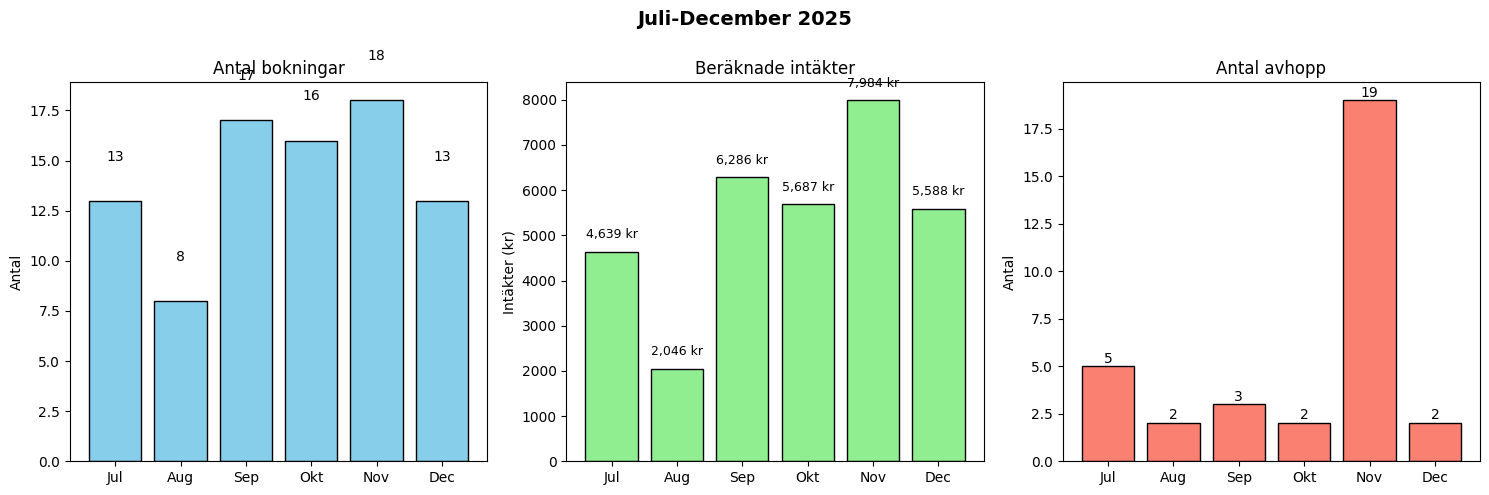

SUMMERING JULI-DEC 2025
Totalt bokningar: 85
Unika medlemmar: 43
Beräknade intäkter: 32,230 kr
Totala avhopp: 33


In [4]:
# Säkerställ datum
datum_kolumner = ['passdatum', 'medlem_slutdatum']
for kolumn in datum_kolumner:
    df_feat[kolumn] = pd.to_datetime(df_feat[kolumn], errors='coerce')

# Skapa månadskolumn
df_feat['månad'] = df_feat['passdatum'].dt.strftime('%Y-%m')

# Filtrera för juli-dec 2025
månader = ['2025-07', '2025-08', '2025-09', '2025-10', '2025-11', '2025-12']
period = df_feat[df_feat['månad'].isin(månader)].copy()

# Förbered data för diagram
månadsnamn = ['Jul', 'Aug', 'Sep', 'Okt', 'Nov', 'Dec']

# Bokningar per månad
bokningar = period.groupby('månad').size().reindex(månader, fill_value=0)

# Intäkter per månad (simplifierat)
medlemsinfo = period[['medlem_id', 'månadskostnad', 'månad']].drop_duplicates()
intäkter = medlemsinfo.groupby('månad')['månadskostnad'].sum().reindex(månader, fill_value=0)

# Avhopp per månad
period['avhopp_månad'] = period['medlem_slutdatum'].dt.strftime('%Y-%m')
avhopp_data = period[period['avhopp_månad'].notna()].groupby('avhopp_månad').size()
avhopp = pd.Series([0]*6, index=månader)
for månad, antal in avhopp_data.items():
    if månad in avhopp.index:
        avhopp[månad] = antal

# Skapa Diagram
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Diagram 1
ax1.bar(månadsnamn, bokningar, color='skyblue', edgecolor='black')
ax1.set_title('Antal bokningar')
ax1.set_ylabel('Antal')
for i, v in enumerate(bokningar):
    ax1.text(i, v + 2, str(v), ha='center')

# Diagram 2  
ax2.bar(månadsnamn, intäkter, color='lightgreen', edgecolor='black')
ax2.set_title('Beräknade intäkter')
ax2.set_ylabel('Intäkter (kr)')
for i, v in enumerate(intäkter):
    ax2.text(i, v + 300, f'{v:,.0f} kr', ha='center', fontsize=9)

# Diagram 3
ax3.bar(månadsnamn, avhopp, color='salmon', edgecolor='black')
ax3.set_title('Antal avhopp')
ax3.set_ylabel('Antal')
for i, v in enumerate(avhopp):
    ax3.text(i, v + 0.2, str(v), ha='center')

plt.suptitle('Juli-December 2025', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# 7. Summering
print("="*50)
print("SUMMERING JULI-DEC 2025")
print("="*50)
print(f"Totalt bokningar: {len(period)}")
print(f"Unika medlemmar: {period['medlem_id'].nunique()}")
print(f"Beräknade intäkter: {intäkter.sum():,.0f} kr")
print(f"Totala avhopp: {avhopp.sum()}")
print("="*50)

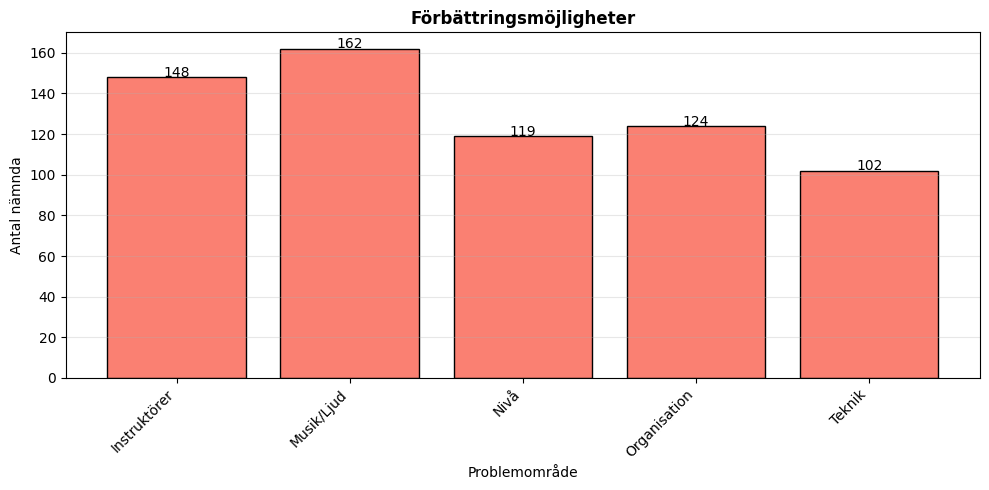

In [5]:
feedback_data = df_feat[df_feat['feedback_text'].notna()].copy()

if len(feedback_data) > 0:
    # Definiera NEGATIVA söktermer med kontext
    negativa_uttryck = {
        'Instruktörer': [
            'dålig instruktör', 'tråkig tränare', 'instruktören var dålig',
            'instruktören kunde inte', 'instruktören behöver förbättras'
        ],
        'Musik för hög': [
            'musiken för hög', 'för högt ljud', 'för hög volym',
            'öronbedövande musik', 'musiken var för stark'
        ],
        'För svårt pass': [
            'för svårt', 'för avancerat', 'nivån för hög',
            'passet för svårt', 'för mycket för nybörjare'
        ],
        'Organisationsproblem': [
            'dålig planering', 'för rörigt', 'för lång kö',
            'dålig information', 'för sent start'
        ]
    }
    
    # Räkna negativa nämnanden
    problem = {}
    
    for område, termer in negativa_uttryck.items():
        räknare = 0
        for text in feedback_data['feedback_text']:
            if pd.isna(text):
                continue
                
            text_lower = text.lower()
            # Kolla om NÅGON av de negativa termerna finns
            if any(term in text_lower for term in termer):
                räknare += 1
        
        if räknare >= 2:  # Minst 2 nämnanden
            problem[område] = räknare

if len(feedback_data) > 0:
    # Enkelt räkna viktiga problem
    problem = {
        'Instruktörer': feedback_data['feedback_text'].str.contains('instruktör|tränare', case=False, na=False).sum(),
        'Musik/Ljud': feedback_data['feedback_text'].str.contains('musik|ljud|hög', case=False, na=False).sum(),
        'Nivå': feedback_data['feedback_text'].str.contains('nivå|svår|lätt|nybörjare', case=False, na=False).sum(),
        'Organisation': feedback_data['feedback_text'].str.contains('planering|rörig|organiser', case=False, na=False).sum(),
        'Teknik': feedback_data['feedback_text'].str.contains('teknik|skador|risk', case=False, na=False).sum()
    }
    
    # Ta bort nollor
    problem = {k: v for k, v in problem.items() if v > 0}
    
    if problem:
        # Skapa diagram
        plt.figure(figsize=(10, 5))  # Gör diagrammet lite bredare
        
        områden = list(problem.keys())
        antal = list(problem.values())
        
        plt.bar(områden, antal, color='salmon', edgecolor='black')
        
        plt.title('Förbättringsmöjligheter', fontweight='bold')
        plt.ylabel('Antal nämnda')  # Y-axeln = antal
        plt.xlabel('Problemområde')  # X-axeln = områden
        
        # Rotera x-axelns texter så de inte överlappar
        plt.xticks(rotation=45, ha='right')
        
        # Lägg till siffror på toppen av staplarna
        for i, v in enumerate(antal):
            plt.text(i, v + 0.2, str(v), ha='center', fontsize=10)
        
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()  # Se till att allt får plats
        plt.show()
                
    else:
        print("Inga problem identifierade i feedbacken.")
        
else:
    print("Ingen feedback att analysera.")

